<a href="https://colab.research.google.com/github/kei-mo/TheoriticalNeuroscience/blob/master/Chapter8_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 9 : Classical Conditioning and Reinforcement Learning

In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
import numpy as np
import random
from IPython.display import HTML

%matplotlib inline
# To make an animation, we need ffmpeg
!apt-get update && apt-get install ffmpeg

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [801 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,609 B]
Get:12 http://security.ubuntu.com/ubuntu bionic

## 9.1 Classical conditioning

### Prediction rewards: The Recorla-Wagner Rule

$v =wu$  
$w \leftarrow w + \epsilon \delta u $  
$\delta = r - u $

#### Acquire and Extinction

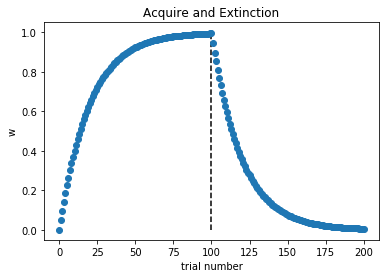

In [0]:
epsilon = 0.05
w_list = [0]

# Acquire
for i in range(0,100):
    r = 1
    u = 1
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

# Extinction
for i in range(100,200):
    u = 1 
    r = 0
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
    
plt.plot(w_list, "o")
plt.vlines(100,0,1,linestyle='dashed')

plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Acquire and Extinction")
plt.show()

#### Partial reinforcment

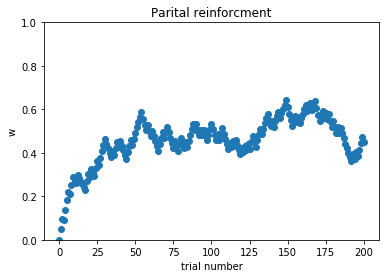

In [0]:
epsilon = 0.05
w_list = [0]
for i in range(200):
    u = 1 
    r = 1 if np.random.rand()>0.5 else 0
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
plt.plot(w_list,"o")
plt.ylim(0,1)
plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Parital reinforcment")

plt.show()

#### Blocking

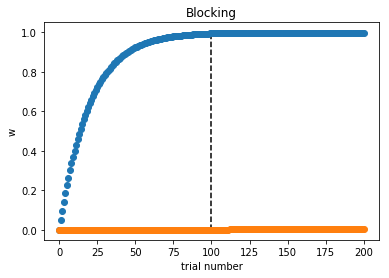

In [0]:
epsilon = 0.05
w_list = [[0,0]]

# Pretrain
r = 1
u = np.array([1,0])
for i in range(0,100):
    v = np.dot(w_list[i],u)
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

# Train
r = 1
u = np.array([1,1])
for i in range(100,200):
    v = np.dot(w_list[i],u)
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

    
    
plt.plot(w_list, "o")
plt.vlines(100,0,1,linestyle='dashed')
plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Blocking")

plt.show()

#### Inhibitory

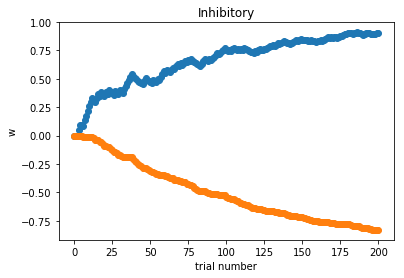

In [0]:
epsilon = 0.05
w_list = [[0,0]]

# Train
r = 1
u = np.array([1,1])
for i in range(0,200):
    if np.random.rand()>0.5:
        r = 0
        u = np.array([1,1])
        v = np.dot(w_list[i],u)
        delta = r - v
        w = w_list[i] + epsilon * delta * u
    else:
        r = 1
        u = np.array([1,0])
        v = np.dot(w_list[i],u)
        delta = r - v
        w = w_list[i] + epsilon * delta * u
    w_list.append(w)

    
    
plt.plot(w_list, "o")
plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Inhibitory")

plt.show()

#### Overshadow

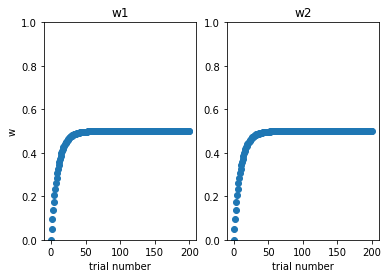

In [0]:

epsilon = 0.05
w_list = [[0,0]]

# Train
r = 1
u = np.array([1,1])
for i in range(0,200):
    r = 1
    u = np.array([1,1])
    v = np.dot(w_list[i],u)
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

    
plt.subplot(1, 2, 1)
plt.plot(np.array(w_list)[:,0], "o")
plt.xlabel("trial number")
plt.ylabel("w")
plt.ylim(0,1)
plt.title("w1")

plt.subplot(1, 2, 2)
plt.plot(np.array(w_list)[:,1], "o")
plt.xlabel("trial number")
plt.ylim(0,1)
plt.title("w2")

plt.show()

### Temporal difference 

In [0]:
import copy
trial_num = 400
trial_len = 250
epsilon = 0.5


stumulate_time = 100
reward_time = 200

# stiumlus
u_list = np.array([0]*trial_len)
u_list[stumulate_time] = 1

# reward
r_list = [0]*trial_len
r_list[reward_time] = 1

# weight
w_list = [0] * trial_len
# value
v_list = [0] * trial_len

#history
v_list_hist = []
delta_list_hist = []
# initialize w[tau][t][trial]
w_list_hist = np.zeros((trial_len,trial_len+1,trial_num))



delta_list = [0] * trial_len
for trial in range(trial_num):
    delta_list = []
    for t in range(trial_len - 1):
        next_v = v_list[t+1]
        v = v_list[t]
        delta = r_list[t] + next_v - v # temporal difference
        delta_list.append(delta)
        for tau in range(t+1):
            w_list[tau] = w_list[tau] + epsilon * delta * u_list[t-tau]
            w_list_hist[tau][t][trial] = copy.copy(w_list[tau])
        v_list[t] = np.sum([w*u for w,u in zip(w_list[:t+1], u_list[:t+1][::-1])])
    delta_list_hist.append(delta_list.copy())
    v_list_hist.append(v_list.copy())

#v_history = [v_list]#
#delta_history = []

#### Plot

**u**

Text(0, 0.5, 'reward')

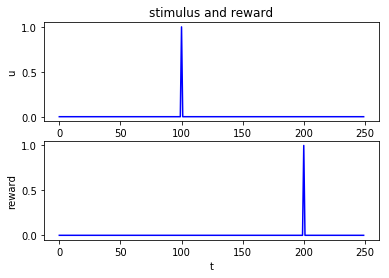

In [8]:
plt.subplot(2,1,1)
plt.plot(u_list,"b")
plt.xlabel("t")
plt.ylabel("u")

plt.title("stimulus and reward")


plt.subplot(2,1,2)
plt.plot(r_list,"b")
plt.xlabel("t")
plt.ylabel("reward")



**Value**

In [9]:
fig = plt.figure()
images = []
for i in range(trial_num):
    image = plt.plot(v_list_hist[i],"b")
    images.append(image)
plt.close()

ani = animation.ArtistAnimation(fig, images, interval=50)
rc('animation', html='jshtml')
ani

# for saving
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
HTML(ani.to_html5_video())

**TD**

In [10]:
fig = plt.figure()
images = []
for i in range(trial_num):
    image = plt.plot(delta_list_hist[i],"b")
    images.append(image)
    
plt.close()

ani = animation.ArtistAnimation(fig, images, interval=50)
rc('animation', html='jshtml')
ani

# for saving
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
HTML(ani.to_html5_video())

**w**

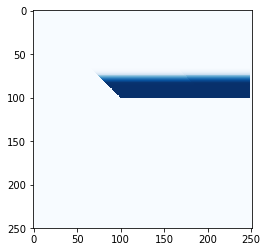

In [26]:
w_list_hist=np.array(w_list_hist)
fig = plt.figure()

def animate(i):
    plt.imshow(w_list_hist[:,:,i],"Blues")
    #
    # plt.xlavel("tau")
    

ani = animation.FuncAnimation(fig, animate, frames=50)
# ani = animation.ArtistAnimation(fig, images, interval=50)
rc('animation', html='jshtml')
ani

# for saving
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
HTML(ani.to_html5_video())

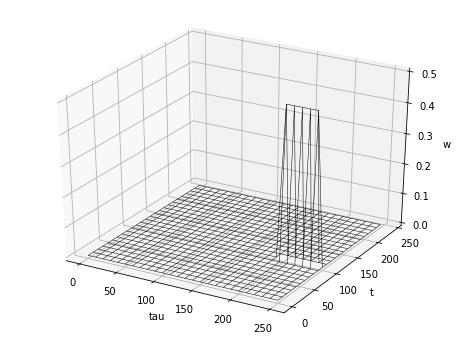

In [0]:
from mpl_toolkits.mplot3d import axes3d

Nfrm = trial_num
space = 10
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# # Make the X, Y meshgrid.
# xs = np.linspace(-1, 1, 50)
# ys = np.linspace(-1, 1, 50)
# X, Y = np.meshgrid(xs, ys)

# # Set the z axis limits so they aren't recalculated each frame.
# ax.set_zlim(-1, 1)
trial_len = 250
x = np.arange(0,trial_len+1,space)
y = np.arange(0,trial_len,space)
X, Y = np.meshgrid(x, y)

# Begin plotting.
wframe = None
Z = w_list_hist[::space,::space,0]
def update(idx):
    phi=phis[idx]
    global wframe
    # If a line collection is already remove it before drawing.
    if wframe:
        ax.collections.remove(wframe)

    # Plot the new wireframe and pause briefly before continuing.
#     Z = generate(X, Y, phi)
    Z = w_list_hist[::space,::space,idx]
    wframe = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, color='k', linewidth=0.5)
    ax.set_xlabel("tau")
    ax.set_ylabel("t")
    ax.set_zlabel("w")
phis = np.arange(trial_num)
ani = animation.FuncAnimation(fig, update, Nfrm, interval=50)
plt.rc('animation', html='jshtml')
ani

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
HTML(ani.to_html5_video())

## 9.3 Static Action Choice

**Bee Foraing Task**  
This task is simplication version of multi-armed bandit task

In [0]:
class Bandit():
    def __init__(self, arm_num):
        self.mean_reward = [0]*arm_num
        
    def return_reward(self,arm):
        reward = random.gauss(self.mean_reward[arm], 0.8)
        return reward

In [0]:
def softmax(x, beta):
    e_x = np.exp(beta*(x - np.max(x)))
    return e_x / e_x.sum()

### Indirect actor


$m_b \leftarrow m_b + \epsilon \delta $  
$\delta = r_b - m_b $

In [0]:

epsilon = 0.1
beta = 1

m = [0, 0] # action values
visit = [0,0]

# history
m_hist = [m]
visit_hist = [visit]


flower_env = Bandit(2)
flower_env.mean_reward = [1, 2]
for i in range(0,100):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)
    delta = reward - m[action] # delta
    m[action] = m[action] +  epsilon * delta 
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])
    
    
# Change mean reward(nector volume) of each flower at t=100
flower_env.mean_reward = [2, 1]
for i in range(100,200):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)
    delta = reward - m[action]
    m[action] = m[action] +  epsilon * delta 
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])

m_hist = np.array(m_hist)
visit_hist = np.array(visit_hist)

Values of $m_b$ and $m_y$

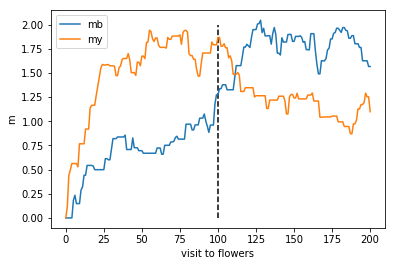

In [34]:
plt.plot(m_hist[:,0], label="mb")
plt.plot(m_hist[:,1], label="my")
plt.vlines(100,0,2,linestyle='dashed')

plt.xlabel("visit to flowers")
plt.ylabel("m")
plt.legend()

Sum visit to flower

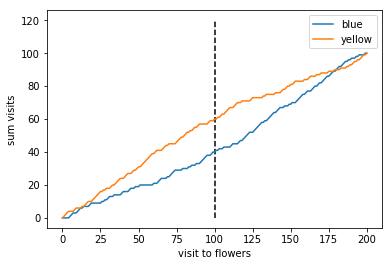

In [35]:
plt.plot(visit_hist[:,0].cumsum(), label="blue")
plt.plot(visit_hist[:,1].cumsum(), label="yellow")
plt.vlines(100,0,120,linestyle='dashed')

plt.xlabel("visit to flowers")
plt.ylabel("sum visits")
plt.legend()

### Direct actor

In [0]:

epsilon = 0.1
beta = 1
r_bar = 1.5

m = [0.0, 0.0] # action values
visit = [0,0]

# history
m_hist = [m]
visit_hist = [visit]


flower_env = Bandit(2)
flower_env.mean_reward = [1, 2]
for i in range(0,100):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)
    
    
    kdb = 1 if action==0 else 0
    kdy = 1 if action==1 else 0 
    m[0] = m[0] + epsilon * (kdb - action_prob[0]) * (reward - r_bar)
    m[1] = m[1] + epsilon * (kdy - action_prob[1]) * (reward - r_bar)
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])
    
    
# Change mean reward(nector volume) of each flower at t=100
flower_env.mean_reward = [2, 1]
for i in range(100,300):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)

    
    
    kdb = 1 if action==0 else 0
    kdy = 1 if action==1 else 0 
    m[0] = m[0] + epsilon * (kdb - action_prob[0]) * (reward - r_bar)
    m[1] = m[1] + epsilon * (kdy - action_prob[1]) * (reward - r_bar)
    
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])

m_hist = np.array(m_hist)
visit_hist = np.array(visit_hist)

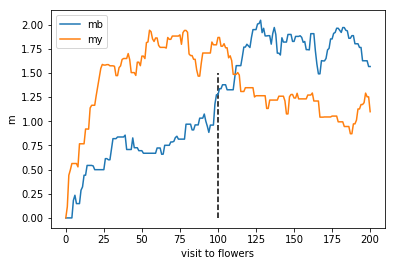

In [36]:
plt.plot(m_hist[:,0], label="mb")
plt.plot(m_hist[:,1], label="my")
plt.xlabel("visit to flowers")
plt.ylabel("m")
plt.legend()

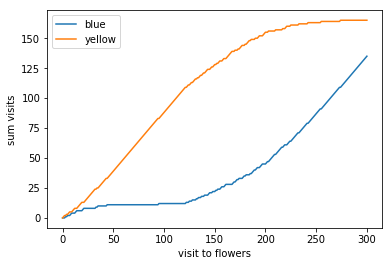

In [0]:
plt.plot(visit_hist[:,0].cumsum(), label="blue")
plt.plot(visit_hist[:,1].cumsum(), label="yellow")
plt.xlabel("visit to flowers")
plt.ylabel("sum visits")
plt.legend()

## Actor - Critic

In [0]:
class Environment():
    def __init__(self):
        self.state_num = 7

        self.transition_dict = {"A":["B","C"],
                          "B":["BL","BR"],
                          "C":["CL","CR"],
                          "BL":[],
                          "BR":[],
                          "CL":[],
                          "CR":[]}
        self.reward_dict = {"A":0,
                      "B":0,
                      "C":0,
                      "BL":0,
                      "BR":5,
                      "CL":2,
                      "CR":0}

In [0]:
class Critic():
    def __init__(self,env):
        self.state_num = env.state_num
        self.V = {"A":0,
                  "B":0,
                  "C":0,
                  "BL":0,
                  "BR":0,
                  "CL":0,
                  "CR":0}

In [0]:
class Actor():
    def __init__(self,env):
        self.state_num = env.state_num
        self.M = {"A":[0,0],
                  "B":[0,0],
                  "C":[0,0],
                  "BL":[0,0],
                  "BR":[0,0],
                  "CL":[0,0],
                  "CR":[0,0]}
    
    def softmax(self,x, beta):
        e_x = np.exp(beta*(x - np.max(x)))
        return e_x / e_x.sum()

#### Critic only

In [0]:
epsilon = 0.5
trail_num = 100
env = Environment()
critic = Critic(env)


a_total_hist = []
b_total_hist = []
c_total_hist = []
for k in range(50):
    env = Environment()
    critic = Critic(env)

    a_hist = []
    b_hist = []
    c_hist = []
    for i in range(trail_num):
        u="A"
        for j in range(2):
            action = 0 if np.random.rand() >0.5 else 1
            next_u = env.transition_dict[u][action]
            r = env.reward_dict[next_u]
            td = r + critic.V[next_u]-critic.V[u]
            critic.V[u] = critic.V[u] + epsilon * td
            u=next_u

        a_hist.append(critic.V["A"])
        b_hist.append(critic.V["B"])
        c_hist.append(critic.V["C"])
    
    a_total_hist.append(a_hist)
    b_total_hist.append(b_hist)
    c_total_hist.append(c_hist)

a_average = np.mean(a_total_hist,axis=0)
b_average = np.mean(b_total_hist,axis=0)
c_average = np.mean(c_total_hist,axis=0)

#### Plot

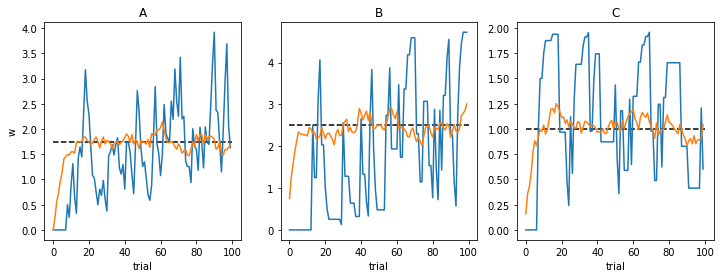

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(a_hist)
plt.plot(a_average)
plt.hlines(1.75,0,100,linestyle='dashed')
plt.xlabel("trial")
plt.ylabel("w")
plt.title("A")

plt.subplot(1,3,2)
plt.hlines(2.5,0,100,linestyle='dashed')

plt.plot(b_hist)
plt.plot(b_average)
plt.xlabel("trial")

plt.title("B")


plt.subplot(1,3,3)
plt.hlines(1,0,100,linestyle='dashed')

plt.plot(c_hist)
plt.plot(c_average)
plt.xlabel("trial")

plt.title("C")
plt.show()

### Actor Critic

In [0]:
epsilon = 0.5
beta = 1
trail_num = 100
env = Environment()
critic = Critic(env)
actor = Actor(env)

a_m_hist =[]
b_m_hist =[]
c_m_hist =[]



for i in range(trail_num):
    u = "A"
    for j in range(2):
        # transition
        m = actor.M[u].copy()
        action_prob = actor.softmax(m, beta)
        action = random.choices([0,1], weights=action_prob)[0]
        next_u = env.transition_dict[u][action]
        r = env.reward_dict[next_u]
        
        # td
        td = r + critic.V[next_u]-critic.V[u]
        
        # Policy imporvement Actor
        kdl = 1 if action==0 else 0
        kdr = 1 if action==1 else 0 
        m[0] = m[0] + epsilon * (kdl - action_prob[0]) * td
        m[1] = m[1] + epsilon * (kdr - action_prob[1]) * td
        actor.M[u] = m.copy()
        
        # Policy Evaluation Crtic
        critic.V[u] = critic.V[u] + epsilon * td
        
        # next
        u=next_u
    
    a_m_hist.append(actor.M["A"].copy())
    b_m_hist.append(actor.M["B"].copy())
    c_m_hist.append(actor.M["C"].copy())

        

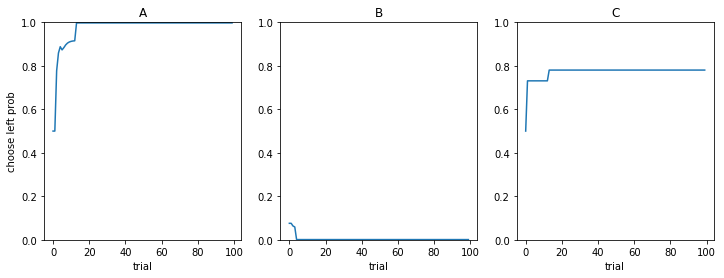

In [47]:
plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.plot([softmax(m,beta)[0] for m in np.array(a_m_hist)])
plt.ylim(0,1)
plt.xlabel("trial")
plt.ylabel("choose left prob")
plt.title("A")

plt.subplot(1,3,2)
plt.plot([softmax(m,beta)[0] for m in np.array(b_m_hist)])
plt.ylim(0,1)
plt.xlabel("trial")
plt.title("B")

plt.subplot(1,3,3)
plt.plot([softmax(m,beta)[0] for m in np.array(c_m_hist)])
plt.ylim(0,1)
plt.xlabel("trial")
plt.title("C")
plt.show()